In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
import os
import random

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
#!pip install arff


In [2]:
df1= pd.read_csv('yelpfinal2.csv')

## Preprocessing

In [4]:
df1.columns.values

array(['business_id', 'user_id', 'review_id', 'stars_review',
       'useful_review', 'funny_review', 'cool_review', 'text', 'date',
       'name_user', 'review_count_user', 'yelping_since', 'useful_user',
       'funny_user', 'cool_user', 'elite_user', 'friends', 'fans',
       'average_stars_user', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'name_business', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count_business'],
      dtype=object)

In [5]:
#Subsetting the data to only have columns that have numeric data in them
numeric_col= df1[['stars_review','useful_review','funny_review','cool_review',
                  'review_count_user','useful_user','funny_user','cool_user',
                  'elite_user','fans','average_stars_user','compliment_hot', 'compliment_more',
                    'compliment_profile', 'compliment_cute', 'compliment_list',
                    'compliment_note', 'compliment_plain', 'compliment_cool',
                    'compliment_funny', 'compliment_writer', 'compliment_photos','stars_business']]

In [7]:
numeric_col.isna().sum().sum()

0

In [8]:
# I split the data because I didnt want to use everything for the predictions. numeric_set1 is what I worked on primarily in the regression below. We could use numeric_set2 as a larger test set
numeric_set1=numeric_col.sample(frac=0.5, replace=False, random_state=1)
#numeric_set1 = numeric_col.iloc[:9000,:]
#numeric_set2 = df.iloc[9000:,:]

In [10]:
#had to chane the data type of the dependent variable because it wasnt categorical and wouldnt work otherwise in any regressioin function
numeric_set1['stars_business'] = numeric_set1['stars_business'].apply(np.int64)

In [11]:
#split data into x and y variables
numeric_set1X=numeric_set1[['stars_review','useful_review','funny_review','cool_review',
                  'review_count_user','useful_user','funny_user','cool_user',
                  'elite_user','fans','average_stars_user','compliment_hot', 'compliment_more',
                    'compliment_profile', 'compliment_cute', 'compliment_list',
                    'compliment_note', 'compliment_plain', 'compliment_cool',
                    'compliment_funny', 'compliment_writer', 'compliment_photos']]
numeric_set1y=numeric_set1['stars_business']

In [12]:
#Split into train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(numeric_set1X, numeric_set1y, test_size=0.46, random_state=2022)

## PCA Reduction

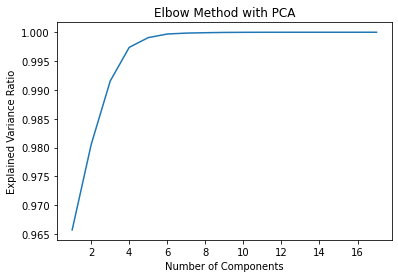

In [13]:
from sklearn.decomposition import PCA
#from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
# import numpy as np

n_components = min(17, X_train.shape[1]) # choose the minimum between 5 and the number of features

# compute the explained variance ratio for each number of components
variance_ratios = []
for i in range(1, n_components + 1):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    variance_ratios.append(pca.explained_variance_ratio_.sum())

# plot the explained variance ratio for each number of components
plt.plot(range(1, n_components + 1), variance_ratios)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method with PCA')
plt.show()



In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_reduction(data,n_components):
    # Data standardization
    standardized_data = StandardScaler().fit_transform(data)

    # PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(standardized_data)

    return reduced_data



In [15]:
reduce_train=pd.DataFrame(pca_reduction(X_train, 4))
reduce_test= pca_reduction(X_test, 4)

In [16]:
reduce_train

,0,1,2,3
0,0.030510,-0.453766,-0.683762,0.739304
1,-0.597688,0.271488,-0.453985,0.704660
2,-0.585580,0.178954,-1.066862,1.025537
3,-0.574265,0.196461,-0.891239,0.876445
4,-0.606224,0.417391,0.542547,0.152022
...,...,...,...,...
6713,-0.404518,-0.006315,0.621860,0.137103
6714,-0.586194,0.226133,-0.728255,0.834447
6715,-0.607041,0.406944,0.555250,0.103414
6716,-0.588900,0.208898,-0.866162,0.916313


## Decision Tree

In [18]:
#regression tree on train data
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

from sklearn import metrics
print("Train Accuracy:",metrics.accuracy_score(y_train, tree_clf.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, tree_clf.predict(X_test)))

Train Accuracy: 0.6201250372134564
Test Accuracy: 0.6142557651991615


#### Random Search with regular data

In [19]:
#decision tree grid search

param_grid = {
    'max_depth': [2,3,4,5,6,],
    'min_samples_split': [32, 33, 34, 35, 36],
    'min_samples_leaf': [ 19, 20, 21, 22],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier()

# Define the grid search
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, cv=4, n_iter=50, random_state=42)

# Fit the grid search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = random_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = random_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

Best parameters: {'splitter': 'random', 'min_samples_split': 34, 'min_samples_leaf': 20, 'max_depth': 3}
Best score: 0.6192327668113107
Test accuracy: 0.6128581411600279


In [20]:
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=21, min_samples_split=35, splitter='random')
tree_clf.fit(X_train, y_train)

from sklearn import metrics
print("Train Accuracy:",metrics.accuracy_score(y_train, tree_clf.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, tree_clf.predict(X_test)))

Train Accuracy: 0.6189342066091098
Test Accuracy: 0.6147798742138365


#### Random search with reduced data

In [21]:
#decision tree grid search
param_grid = {
    'max_depth': [1,2,3,4,5,6,7],
    'min_samples_split': [32, 33, 34, 35, 36, 37],
    'min_samples_leaf': [18, 19, 20, 21, 22],
    'splitter': ['best', 'random']
}
dt = DecisionTreeClassifier()

# Define the grid search
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, cv=4, n_iter=50, random_state=42)

# Fit the grid search to the data
random_search.fit(reduce_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = random_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = random_search.predict(reduce_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

Best parameters: {'splitter': 'best', 'min_samples_split': 32, 'min_samples_leaf': 19, 'max_depth': 3}
Best score: 0.6149151635043535
Test accuracy: 0.613382250174703


In [22]:
#regression tree visual
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        feature_names=X_train.columns[0:],
        class_names='stars_business',
        rounded=True,
        filled=True
    )

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="stars_review <= 3.908\\ngini = 0.571\\nsamples = 6718\\nvalue = [142, 540, 1552, 4057, 427]\\nclass = r", fillcolor="#a09ff2"] ;\n1 [label="stars_review <= 2.396\\ngini = 0.688\\nsamples = 2073\\nvalue = [135, 406, 744, 778, 10]\\nclass = r", fillcolor="#fafafe"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="stars_review <= 1.444\\ngini = 0.706\\nsamples = 1598\\nvalue = [127, 377, 579, 506, 9]\\nclass = a", fillcolor="#f2fdfb"] ;\n1 -> 2 ;\n3 [label="elite_user <= 0.586\\ngini = 0.719\\nsamples = 1182\\nvalue = [120, 322, 417, 318, 5]\\nclass = a", fillcolor="#e9fcf9"] ;\n2 -> 3 ;\n4 [label="gini = 0.719\\nsamples = 1140\\nvalue = [117, 315, 399, 304, 5]\\nclass = a", fillcolor="#ebfcf9"] ;\n3 -> 4 ;\n5 [label="gini = 0.672\\nsamples = 42\\nvalue = [3, 7, 18, 14, 0]\\nclass = a", fillcolor="#e3fbf7"] ;\n3 -> 5 ;\n6 [l

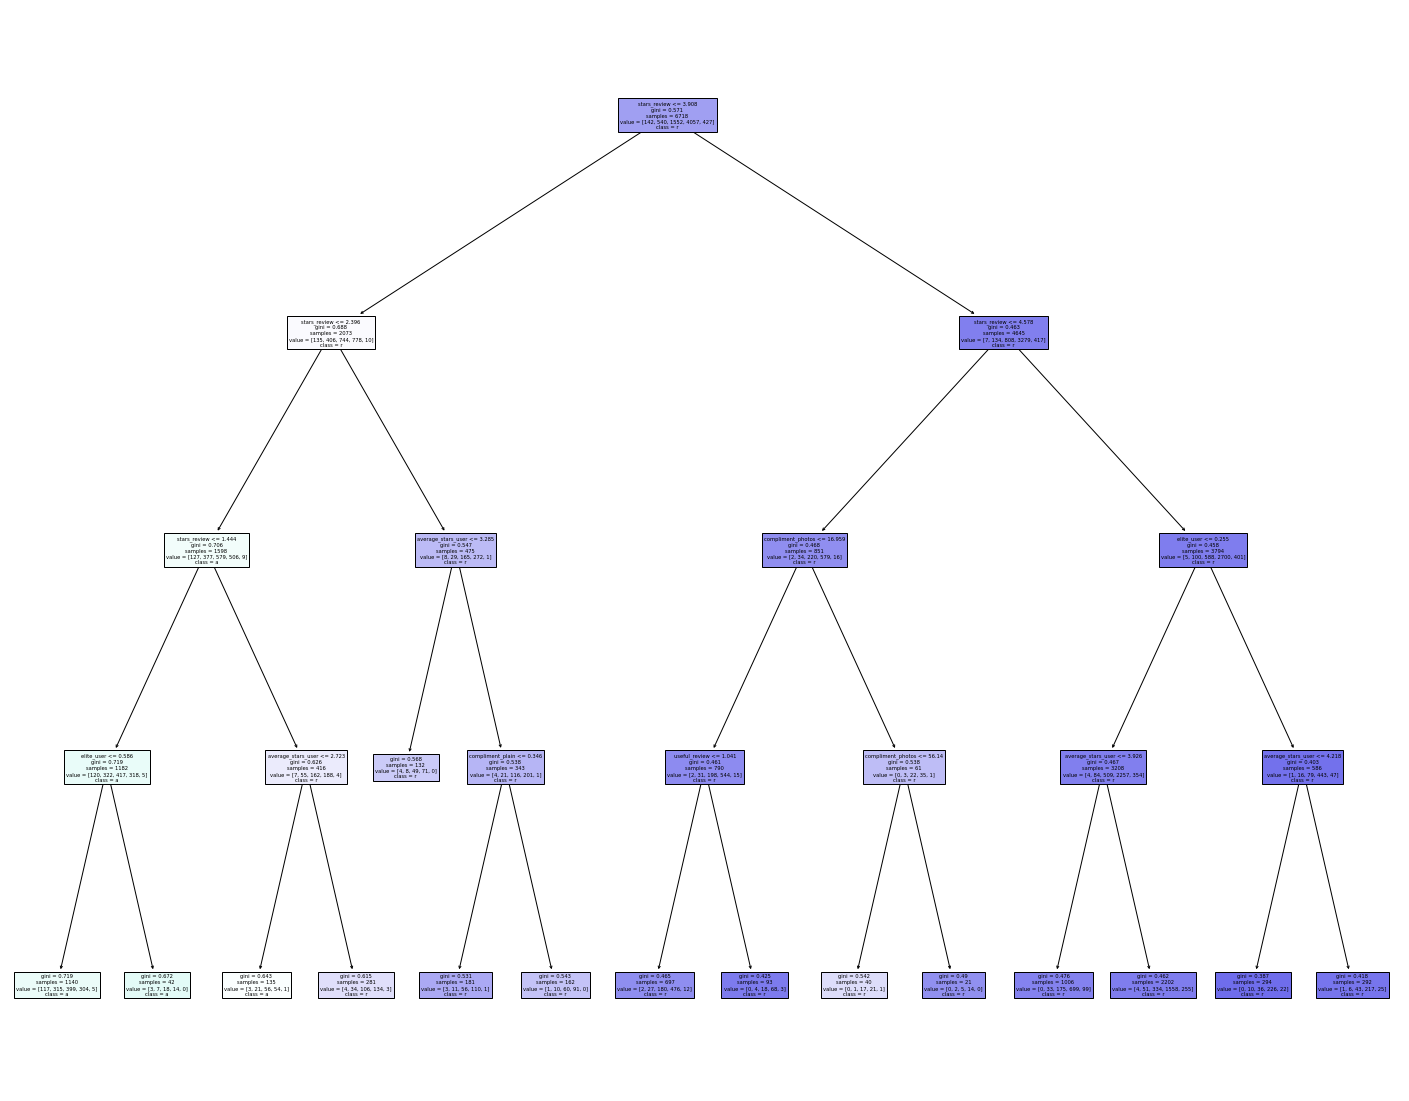

In [23]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf,
                   feature_names=X_train.columns[0:],
                   class_names='stars_business',
                   filled=True)

## Random Forest

#### No Parameters

In [24]:
#No parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rnd_clf = RandomForestClassifier(n_estimators=400, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_rf))

Test Accuracy:  0.606219426974144


#### Random Search with regular data

In [25]:
#Random forrest grid search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create random forest classifier
rf = RandomForestClassifier()

# Define grid search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=4, n_iter=50, random_state=42)

# Fit grid search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = random_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = random_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")



Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 15, 'bootstrap': True}
Best score: 0.615808818315891
Test accuracy: 0.6135569531795947


#### Random Search with reduced data

In [26]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create random forest classifier
rf = RandomForestClassifier()

# Define grid search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=4, n_iter=50, random_state=42)

# Fit grid search to the data
random_search.fit(reduce_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = random_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = random_search.predict(reduce_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
Best score: 0.6174461662270626
Test accuracy: 0.6154786862334032


## Multi-class Ordinal Logistic Regression

### No parameters

In [27]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Initialize the multi-class ordinal logistic regression model
ordinal_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model on the training data
ordinal_logistic.fit(X_train, y_train)

# Predict the classes for the test data
y_pred = ordinal_logistic.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Mean Squared Error: 0.8006638714185884
Accuracy: 0.60062893081761


c:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Grid search with regular data

In [28]:
#Ordinal logistic regression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'multi_class': ['multinomial', 'ovr'],
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
}

# Create multi-class ordinal logistic regression classifier
lr = LogisticRegression(max_iter=1000)

# Define grid search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")


c:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1519, in fit
    multi_class = _check_multi_class(self.multi_class, solver, len(self.classes_))
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 483, in _check_multi_class
  

Best parameters: {'C': 0.01, 'multi_class': 'ovr', 'solver': 'newton-cg'}
Best score: 0.6186377557352054
Test accuracy: 0.6125087351502446


#### Grid search with reduced data

In [29]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'multi_class': ['multinomial', 'ovr'],
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
}

# Create multi-class ordinal logistic regression classifier
lr = LogisticRegression(max_iter=1000)

# Define grid search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit grid search to the data
grid_search.fit(reduce_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Test on the test set
y_pred = grid_search.predict(reduce_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Best parameters: {'C': 0.001, 'multi_class': 'ovr', 'solver': 'liblinear'}
Best score: 0.6168504901960785
Test accuracy: 0.6154786862334032


c:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1519, in fit
    multi_class = _check_multi_class(self.multi_class, solver, len(self.classes_))
  File "c:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 483, in _check_multi_class
  

## SVM

In [30]:
#SVM model
from sklearn.svm import SVC

svm= SVC(kernel='rbf', gamma=0.4, C=1)
svm.fit(X_train, y_train)

#print("Train Accuracy:",metrics.accuracy_score(y_train, svm.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, svm.predict(X_test)))

Test Accuracy: 0.6063941299790356


In [31]:
#SVM model
from sklearn.svm import SVC

svm= SVC(kernel='rbf', gamma=0.4, C=1)
svm.fit(reduce_train, y_train)

#print("Train Accuracy:",metrics.accuracy_score(y_train, svm.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, svm.predict(reduce_test)))

Test Accuracy: 0.6151292802236199


### Random search with regular data

In [32]:
#The SVM code takes forever to run 
#SVM Grid search
# from sklearn.svm import SVC
# from sklearn import datasets


# param_grid = {
#     'C': [0.1, 1, 10],
#     'gamma': [1, 0.1, 0.01],
#     'kernel': ['linear', 'rbf']#, 'poly', 'sigmoid']
# }

# # instantiate the SVM classifier
# svm = SVC()

# # instantiate the GridSearchCV object
# grid_search = RandomizedSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# # fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# # Get the best score
# best_score = grid_search.best_score_
# print(f"Best score: {best_score}")

# # Test on the test set
# y_pred = grid_search.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# print(f"Test accuracy: {test_accuracy}")